## Tennis Tie-Break Markov Chain

This notebook models a tennis tie-break as a Markov chain, using the [`networkx`](https://networkx.github.io/) package to represent the tie-break as a [graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics%29).

We can use this graph representation to count up the possible outcomes to compute win probabilities for each player.

In a particular tennis game, only one player is serving. In our [previous notebook on modeling a tennis game](https://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/tennis-game-markov_chain-part1.ipynb), we only needed one probability: the probability that the server wins a point on serve. In contrast, under [the rules of a tie-break](http://www.dummies.com/sports/tennis/how-to-play-a-tiebreaker-in-tennis/), players change serve after the first point and ever two serves thereafter. So, to model a tie-break, we need two probabilities: the probabilty that each player wins a point on their serve.

Let's call the players $A$ and $B$, with respective probabilities $a$ and $b$ to win the point on their serve. Notice that this means $(1-a)$ is the probability that $B$ wins the point returning $A$'s serve, and $(1-b)$ is the probability that $A$ wins the point returning $B$'s serve.

Let's assume that player $A$ serves first. This is an arbitrary assumption, since we'll see that the win probability doesn't dependon which player serves first. The serve order is then $ABBAABBAABBA...$, and so on, until one player either gets to 7 points or higher and leads the other player by at least 2 points.

Let's get started modeling the tie-break in Python.

In [1]:
import networkx as nx

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

In [4]:
from pathlib import Path
from collections import Counter, deque
import re

In [5]:
PARENT_DIR = Path.cwd().parent
IMAGES_DIR = PARENT_DIR / 'images'
IMAGES_DIR.mkdir(exist_ok=True, parents=True)

In [6]:
from enum import Enum
from itertools import product

In [7]:
from pracpred.prob import choose
import pracpred.prob as ppp

### Possible Scores in a Tennis Tie-Break

Similar to what we did in [the notebook modeling a tennis game](https://nbviewer.jupyter.org/github/practicallypredictable/posts/blob/master/notebooks/tennis-game-markov_chain-part1.ipynb), we would like to define a Python `class` inheriting from [`Enum`](https://docs.python.org/3/library/enum.html) that specifies all the possible tie-break scores. Using a `class` inheriting from `Enum` allows us to put all the the rules and knowledge about tennis tie-break scores in one place. This is the concept of _encapsulation_ in [object-oriented programming](https://www.python-course.eu/object_oriented_programming.php). In the case of a tennis game, there are only 20 distinct possible points (if you also include the game outcomes of a service hold or break).

Unfortunately, there are many more possible scores in a tennis tie-break. It would be very tedious to have to create an `Enum` specifying all the possible scores. The good news is that it's possible to use Python to create the `Enum` for you, with all the correct values already filled in! Here's how to do it.

Credit to the StackOverflow answers (particularly [this one](https://stackoverflow.com/questions/43096541/a-more-pythonic-way-to-define-an-enum-with-dynamic-members)) by [Ethan Furman](https://stackoverflow.com/users/208880/ethan-furman) for the general approach used in this notebook. The code below actually uses two different Python `class` types. The first is a "factory" `class`, which creates the `Enum` members in its `__new__()` method. The second is the actual `class` we are going to use, which is created by the `create()` method of the factory `class`.

This Python code is relatively advanced, so don't worry if it seems confusing. The upshot is that the `class` we are going to actually use, called `TieBreakScore`, is an `Enum` of the possible scores in a tennis tie-break, along with some additional methods and properties.

In [8]:
class TieBreakScoreEnum(Enum):
    """Factory class to create an Enum of tennis tie-break scores."""
    
    def __new__(cls, score, first_server):
        members = len(cls.__members__)
        member = object.__new__(cls)
        member._value_ = members + 1
        a = score[0]
        b = score[1]
        member._a = a
        member._b = b
        member._state = cls._state(a, b)
        member._server = cls._server(a, b, first_server)
        member._pos = cls._pos(a, b)
        return member
    
    def __str__(self):
        return f'{self._a}-{self._b}'
    
    @property
    def score(self):
        """Score as a string in the format 'A-B'."""
        return str(self)
    
    @property
    def points(self):
        """Points played in this tie-break to reach current score."""
        return self.a + self.b
    
    @property
    def a(self):
        """Player A's points."""
        return self._a
    
    @property
    def b(self):
        """Player B's points."""
        return self._b
    
    @property
    def state(self):
        """Tie-break state, either winner, which player has ad, no ad, or numerical score if less than 6-6."""
        return self._state
    
    @property
    def finished(self):
        """Tie break is over, some player won."""
        return 'wins' in self.state
    
    @property
    def server(self):
        """Which player serves on point played with this current score."""
        return self._server
    
    @property
    def pos(self):
        """Position vector (x, y) to display graph node for this score."""
        return self._pos
    
    def next_score(self, winner):
        """Next score after this score, given point winner."""
        if not self.finished:
            if winner == 'A':
                start_winner = self.a
                start_loser = self.b
            elif winner == 'B':
                start_winner = self.b
                start_loser = self.a
            else:
                raise ValueError('invalid player', winner)
            next_winner, next_loser = TieBreakScoreEnum._next_score(start_winner, start_loser)
            next_a = next_winner if winner == 'A' else next_loser
            next_b = next_winner if winner == 'B' else next_loser
            return self.from_scores(next_a, next_b)
        else:
            return None
    
    @classmethod
    def create(cls, name, first_server='A'):
        """Class factory."""
        return cls(
            value=name,
            names=[
                (cls._name(score), (score, first_server)) for score in cls._generate_scores()
            ]
        )

    @classmethod
    def from_scores(cls, a, b):
        """Score member obtained from more human-readable format representing score A-B."""
        s = f'a{a}b{b}'
        return cls[s]
    
    @classmethod
    def start(cls):
        """Score member for tie-break start 0-0."""
        return cls.from_scores(0, 0)
    
    @classmethod
    def winning_score(cls, player, simple_wins=False):
        """Scores for which a particular player wins tie-break."""
        if player == 'A':
            if simple_wins:
                return [member for member in cls if member.state == 'A wins' and member.a == 7]
            else:
                return [member for member in cls if member.state == 'A wins']
        elif player == 'B':
            if simple_wins:
                return [member for member in cls if member.state == 'B wins' and member.b == 7]
            else:
                return [member for member in cls if member.state == 'B wins']
        else:
            raise ValueError('invalid player', player)

    # Below are helper functions not meant to be called from outside this class.
    
    @staticmethod
    def _generate_scores():
        scores = list(product(range(8), repeat=2))
        scores.remove((7, 7)) # same as 6-6, so remove
        scores.append((8, 6)) # A wins after 6-6
        scores.append((6, 8)) # B wins after 6-6
        return scores
    
    @staticmethod
    def _name(score):
        return f'a{score[0]}b{score[1]}'
            
    @staticmethod
    def _state(a, b):
        if a == 6 and b == 6:
            return 'no ad'
        elif a == 7 and b == 6:
            return 'ad A'
        elif a == 6 and b == 7:
            return 'ad B'
        elif a >= 7:
            return 'A wins'
        elif b >= 7:
            return 'B wins'
        else:
            return f'{a}-{b}'
    
    @staticmethod
    def _server(a, b, first_server):
        UNKNOWN = 'unknown'
        if a >= 7 and b < 6:
            return None # A has already won
        elif b >= 7 and a < 6:
            return None # B has already won
        elif a >= 6 and b >= 6:
            return UNKNOWN # A and B are 6-6 or later, serving alternates
        else:
            if first_server == 'A':
                serve_order = 'ABBA'
            elif first_server == 'B':
                serve_order = 'BAAB'
            else:
                raise ValueError('invalid player', first_server)
            return serve_order[(a+b)%4]

    @staticmethod
    def _pos(a, b):
        if a == 8 or (a == 7 and b < 6):
            return (-4, 15)
        elif b == 8 or (b == 7 and a < 6):
            return (4, 15)
        elif a == 7 and b == 6:
            return (-2, 14)
        elif a == 6 and b == 7:
            return (2, 14)
        else:
            return (b - a), (a + b)

    @staticmethod
    def _next_score(winner, loser):
        if winner <=6:
            if loser == 7:
                return 6, 6
            else:
                return winner+1, loser
        elif winner == 7 and loser == 6:
            return 8, 6
        else:
            raise ValueError('invalid score', winner, loser)

As mentioned above, this first `class` is just a factory, appropriately called `TieBreakScoreEnum`. We call the `create()` class method to actually create the object we want to use.

In [9]:
TieBreakScore = TieBreakScoreEnum.create('TieBreakScore')
type(TieBreakScore)

enum.EnumMeta

Notice that the `type` of this object named `TieBreakScore` is actually a `class`! In Python, [everything is an object](https://jeffknupp.com/blog/2013/02/14/drastically-improve-your-python-understanding-pythons-execution-model/), including classes themselves. Let's look at what's inside this new class.

In [10]:
len(TieBreakScore)

65

This class has 65 members. Let's see what they are.

In [11]:
[member for member in TieBreakScore]

[<TieBreakScore.a0b0: 1>,
 <TieBreakScore.a0b1: 2>,
 <TieBreakScore.a0b2: 3>,
 <TieBreakScore.a0b3: 4>,
 <TieBreakScore.a0b4: 5>,
 <TieBreakScore.a0b5: 6>,
 <TieBreakScore.a0b6: 7>,
 <TieBreakScore.a0b7: 8>,
 <TieBreakScore.a1b0: 9>,
 <TieBreakScore.a1b1: 10>,
 <TieBreakScore.a1b2: 11>,
 <TieBreakScore.a1b3: 12>,
 <TieBreakScore.a1b4: 13>,
 <TieBreakScore.a1b5: 14>,
 <TieBreakScore.a1b6: 15>,
 <TieBreakScore.a1b7: 16>,
 <TieBreakScore.a2b0: 17>,
 <TieBreakScore.a2b1: 18>,
 <TieBreakScore.a2b2: 19>,
 <TieBreakScore.a2b3: 20>,
 <TieBreakScore.a2b4: 21>,
 <TieBreakScore.a2b5: 22>,
 <TieBreakScore.a2b6: 23>,
 <TieBreakScore.a2b7: 24>,
 <TieBreakScore.a3b0: 25>,
 <TieBreakScore.a3b1: 26>,
 <TieBreakScore.a3b2: 27>,
 <TieBreakScore.a3b3: 28>,
 <TieBreakScore.a3b4: 29>,
 <TieBreakScore.a3b5: 30>,
 <TieBreakScore.a3b6: 31>,
 <TieBreakScore.a3b7: 32>,
 <TieBreakScore.a4b0: 33>,
 <TieBreakScore.a4b1: 34>,
 <TieBreakScore.a4b2: 35>,
 <TieBreakScore.a4b3: 36>,
 <TieBreakScore.a4b4: 37>,
 <TieBreak

#### Scores After 6-6

Notice that we only have scores up to a maximum of 8 points to either player $A$ or player $B$. A tie-break could in principle have an infinite number of points, since a player has to win by at least two points. Any tied scores after 6-6 are equivalent to 6-6, and should be treated the same as 6-6. The situation is similar with the ad scores: 8-7 is equivalent to 7-6, and 7-8 is equivalent to 6-7. So we only keep track of of the lowest possible scores after reaching 6-6.

#### Methods and Properties

The `TieBreakScore` object provides a number of methods and properties to make it easier to work with tie-break scores. Here are some examples.

In [12]:
score = TieBreakScore['a7b6']
score.a, score.b

(7, 6)

In [13]:
score.score

'7-6'

In [14]:
score.state

'ad A'

In [15]:
score.next_score(winner='A')

<TieBreakScore.a8b6: 64>

In [16]:
score.next_score(winner='A').state

'A wins'

In [17]:
score.next_score(winner='A').finished

True

In [18]:
score.next_score(winner='B')

<TieBreakScore.a6b6: 55>

In [19]:
score.next_score(winner='B').state

'no ad'

In [20]:
TieBreakScore.winning_score(player='B', simple_wins=True)

[<TieBreakScore.a0b7: 8>,
 <TieBreakScore.a1b7: 16>,
 <TieBreakScore.a2b7: 24>,
 <TieBreakScore.a3b7: 32>,
 <TieBreakScore.a4b7: 40>,
 <TieBreakScore.a5b7: 48>]

Notice that the `winning_score()` method provides for the `simple_wins` parameter. If this parameter is `True`, the method only returns wins for the specified player that don't go through 6-6. This is useful, since 6-6 and later scores need to be handled carefully.

### Modeling a Tennis Tie-Break

Similar to our simple model of a tennis game, there are two basic concepts to model a tie-break. The score is the current state of the tie-break, and a point is the process by which the score changes. Each distinct point has a starting score, and can wind up in two possible ending scores.

In the language of graph theory, this means that the scores can be represented by the [_nodes_](https://en.wikipedia.org/wiki/Vertex_(graph_theory%29) (also called _vertices_) of the graph. The points will be represented by the [_edges_](https://en.wikipedia.org/wiki/Glossary_of_graph_theory_terms#edge) of the graph.

Since we have a `class` to represent the nodes (the scores), let's define a `class` to represent the edges (the points).

In [21]:
class TieBreakPoint:
    """A tennis tie-break point."""
    
    def __init__(self, start_score, end_score):
        self._start = start_score
        self._end = end_score
        self._server = start_score.server
        self._winner = TieBreakPoint._point_winner(start_score, end_score)
        self._label = TieBreakPoint._point_label(self.server, self.winner)
        self._prob_symbol = TieBreakPoint._point_prob_symbol(self.server, self.winner)
        
    @property
    def start(self):
        """Starting score."""
        return self._start
    
    @property
    def end(self):
        """Ending score."""
        return self._end
    
    @property
    def server(self):
        """Player who serves on this point."""
        return self._server
    
    @property
    def winner(self):
        """Player who won this point."""
        return self._winner
    
    @property
    def label(self):
        """Graph edge label for this point."""
        return self._label
    
    @property
    def prob_symbol(self):
        """Symbolic probability of winning player to win this point."""
        return self._prob_symbol
    
    # Below are helper functions not meant to be called from outside this class.
    
    @staticmethod
    def _point_winner(start_score, end_score):
        """Determine who won the point based upon the start and end score."""
        if end_score.state in ['A wins', 'ad A']:
            return 'A'
        elif end_score.state in ['B wins', 'ad B']:
            return 'B'
        elif end_score.state == 'no ad':
            if start_score.state == 'ad A':
                return 'B'
            elif start_score.state == 'ad B':
                return 'A'
            else:
                return 'A' if (end_score.a > start_score.a) else 'B'
        else:
            return 'A' if (end_score.a > start_score.a) else 'B'
        
    @staticmethod
    def _point_label(server, winner):
        if server in ['A', 'B']:
            a_win_label = 'a' if server == 'A' else '1-b'
            b_win_label = '1-a' if server == 'A' else 'b'
        else:
            a_win_label = 'varies'
            b_win_label = 'varies'
        return a_win_label if winner == 'A' else b_win_label
    
    @staticmethod
    def _point_prob_symbol(server, winner):
        if server in ['A', 'B']:
            a_win_symbol = 'a' if server == 'A' else '1-b'
            b_win_symbol = '1-a' if server == 'A' else 'b'
        else:
            a_win_symbol = None
            b_win_symbol = None
        return a_win_symbol if winner == 'A' else b_win_symbol

Similar to the tennis game, we will represent a tie-break graph using the `networkx` package to handle all the details.

In [22]:
class TieBreak:
    """Markov chain model of a tennis tie-break."""
    
    def __init__(self):
        self._G = nx.MultiDiGraph()
        self._add_nodes()
        self._add_edges()
    
    @property
    def graph(self):
        """NetworkX graph object."""
        return self._G
    
    @property
    def scores(self):
        """All possible scores."""
        return [score for score, data in self.graph.nodes(data=True)]
        
    @property
    def points(self):
        """All possible points."""
        return [data['object'] for start_score, end_score, data in self._G.edges(data=True)]
    
    def score_sequences(self, start=TieBreakScore.start(), end=None):
        """All simple paths between a start node and an end node."""
        return (path for path in nx.all_simple_paths(
            self._G,
            source=start,
            target=end,
        ))
    
    def point_sequences(self, start=TieBreakScore.start(), end=None):
        """All simple points paths between a start score and an end score."""
        paths = [list(nx.utils.pairwise(path)) for path in self.score_sequences(start, end)]
        return [[self.graph.edges[(point[0], point[1], 0)]['object'] for point in path] for path in paths]
    
    def simple_win_paths(self, win_score=None, player=None):
        if win_score:
            return list(self.point_sequences(end=win_score))
        else:
            win_scores = TieBreakScore.winning_score(player, simple_wins=True)
            return [path for score in win_scores for path in list(self.point_sequences(end=score))]
    
    def paths_to_no_ad(self):
        return list(self.point_sequences(end=TieBreakScore.from_scores(6, 6)))
    
    def draw(self, ax):
        """Draw graph of the game Markov chain."""
        pos = nx.get_node_attributes(self.graph, 'pos')
        node_labels = {n: d['label'] for n, d in self._G.nodes(data=True)}
        edge_labels = {(n1, n2): d['label'] for n1, n2, d in self._G.edges(data=True)}
        nx.draw_networkx(
            self.graph,
            ax=ax,
            pos=pos,
            node_size=1750,
            node_color='yellow',
            with_labels=False,
            edgecolors='grey'
        )
        nodes = nx.draw_networkx_labels(
            self.graph,
            ax=ax,
            pos=pos,
            labels=node_labels,
        )
        edges = nx.draw_networkx_edge_labels(
            self.graph,
            ax=ax,
            pos=pos,
            label_pos=0.5,
            font_size=8,
            edge_labels=edge_labels,
        )
        return ax
    
    # Below are helper functions not meant to be called from outside this class.
    
    def _add_nodes(self):
        for score in TieBreakScore:
            x, y = score.pos
            self.graph.add_node(
                score,
                label=score.state,
                pos=(x, y),
            )
    
    @staticmethod
    def _get_edges():
        node = TieBreakScore.start()
        nodes_to_check = deque()
        nodes_to_check.append(node)
        nodes_visited = set()
        edges = deque()
        while nodes_to_check:
            node = nodes_to_check.popleft()
            nodes_visited.add(node)
            # Get edge for case when A wins point
            a_wins = node.next_score(winner='A')
            if a_wins:
                edges.append(TieBreakPoint(node, a_wins))
                if a_wins not in nodes_visited and a_wins not in nodes_to_check and not a_wins.finished:
                    nodes_to_check.append(a_wins)
            # Get edge for case when B wins point
            b_wins = node.next_score(winner='B')
            if b_wins:
                edges.append(TieBreakPoint(node, b_wins))
                if b_wins not in nodes_visited and b_wins not in nodes_to_check and not b_wins.finished:
                    nodes_to_check.append(b_wins)
        return edges
    
    def _add_edges(self):
        edges = TieBreak._get_edges()

        for edge in edges:                        
            self._G.add_edge(
                edge.start,
                edge.end,
                label=edge.label,
                prob_symbol=edge.prob_symbol,
                object=edge,
            )

### Analyzing Tie-Breaks

We can use this Python model to do a lot of useful analysis about tennis tie-breaks.

In [23]:
tiebreak = TieBreak()
len(tiebreak.scores)

65

As we saw, this tie-break model distinguishes between 65 different potential points. As discussed above, all equivalent points greater than 6-6 are treated identically. We will have a lot more to say about the implication of this later. Now let's see how many distinct tie-break points the model represents.

In [24]:
len(tiebreak.points)

102

#### Visualizing the Markov Chain

Now let's visualize the tennis tie-break Markov chain.

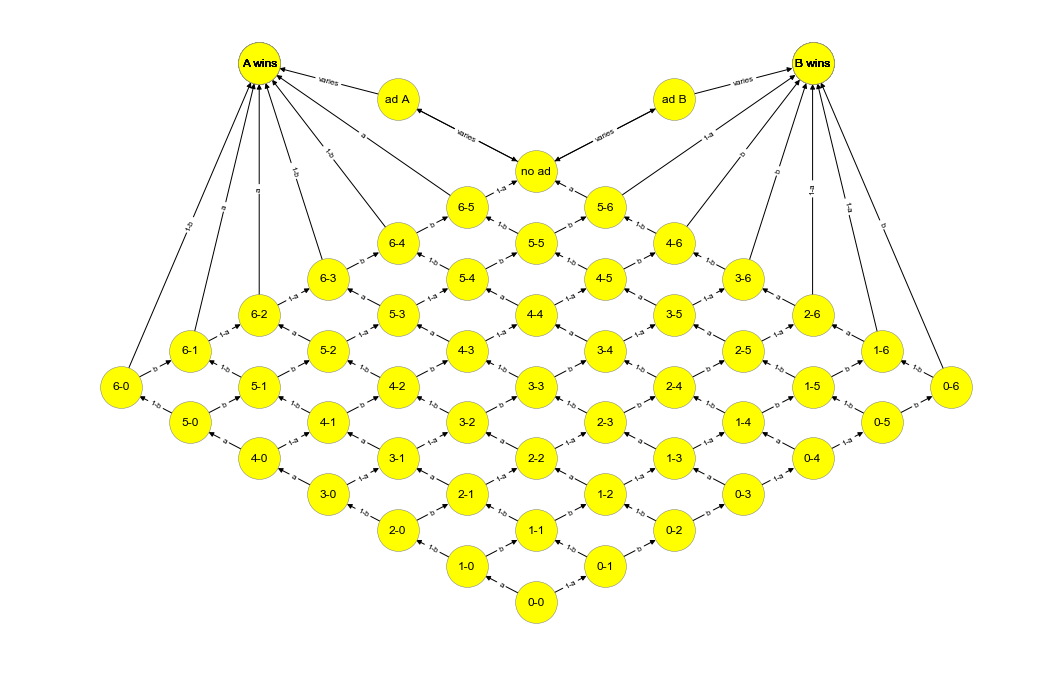

In [25]:
fig, ax = plt.subplots(figsize=(18, 12))
ax = tiebreak.draw(ax)
limits = plt.axis('off')
PNGFILE = IMAGES_DIR.joinpath('tennistiebreakchain.png')
plt.savefig(str(PNGFILE))
plt.show()

You can see the probabilities of winning and losing the point displayed symbolically on each edge of the graph.

You can immediately see how this graph is much more complicated than for the normal tennis game. In addition to having many more potential points, you can see that the probability structure is much more complicated, because of the alternation in serving.

#### Change in Serve

Player $A$ serves for the first point, so the probabilities for the two possible following scores are $a$ (if player $A$ wins the point) and $1-a$ (if player $A$ loses the point). Whether the next score is 1-0 or 0-1, the probabilities for the next level of the graph depend only upon $b$, since player $B$ now has the serve.

Because of the rules about change in serve, we are going to need to keep track of how many points are played to correctly compute the win probabilities for each player.

#### Scores after 6-6

Since 6-6, 7-7 and all later tied scores are equivalent, the Markov chain represents these scores as the same state ("no ad"). Similarly, 7-6, 8-7 and all later scores where $A$ leads by 1 point are equivalent, and are represented by the same state ("ad $A$"). The state "ad $B$" represents 6-7 and all equivalent scores. Notice that in the figure above, the arrows between "no ad" and "ad $A$" point in both directions, since the score can bounce between these two nodes forever. The same is true for the arrows connecting "no ad" and "ad $B$".

Furthermore, if you look at the figure, you will see that probabilities are not well-defined for any of the points after 6-6. Because of the rules for change in serve, the server will alternate each time the tie-break reaches one of these states, even as the score increases. The first time the tie-break reaches 6-6, player $B$ will serve, but if play gets to 7-7, then player $A$ will serve, and so on. The same serve alternation is true for the ad points.

Fortunately, you will see below that this doesn't prevent us from solving for the win probabilities for paths going through 6-6.

#### Path Lengths to a Win

To compute win probabilities, we need to count the number of paths from the start of the game to a win by either player $A$ or player $B$. We have to avoid cycles going through 6-6, which could be infinite.

Let's start with the simple wins for player $A$.

In [26]:
win_scores = TieBreakScore.winning_score(player='A', simple_wins=True)
len(win_scores)

6

In [27]:
[score.score for score in win_scores]

['7-0', '7-1', '7-2', '7-3', '7-4', '7-5']

In [28]:
paths = tiebreak.simple_win_paths(player='A')
len(paths)

792

There are 792 distinct paths from 0-0 to player $A$ getting 7 points, without player $B$ getting 6 points. We will need to know the lengths of these paths in order to figure out who is serving on each point.

In [29]:
Counter(len(path) for path in paths)

Counter({7: 1, 8: 7, 9: 28, 10: 84, 11: 210, 12: 462})

There is only one path with a length of 7 points. That is 7-0, in which $A$ wins every point. We can examine the start score, end score, server, winner, and probability of each point on this path.

In [30]:
[(point.start.score, point.end.score, point.server, point.winner, point.prob_symbol) for point in paths[0]]

[('0-0', '1-0', 'A', 'A', 'a'),
 ('1-0', '2-0', 'B', 'A', '1-b'),
 ('2-0', '3-0', 'B', 'A', '1-b'),
 ('3-0', '4-0', 'A', 'A', 'a'),
 ('4-0', '5-0', 'A', 'A', 'a'),
 ('5-0', '6-0', 'B', 'A', '1-b'),
 ('6-0', '7-0', 'B', 'A', '1-b')]

Notice how the above code automatically keeps track of which player is serving, so the probability of each point is correct. Since the points are independent, we are going to multiply all of these probabilities along each path. Since order doesn't matter in multiplication, we just need to count how many of each probability occur along the path.

In [31]:
Counter([point.prob_symbol for point in paths[0]])

Counter({'1-b': 4, 'a': 3})

#### Symbolically Computing Path Probability

Here is Python code which will compute the probability along each path, using algebra (symbols). Later, we will change focus to the actual numerical values of the probability. For now, however, we want to use Python to find the general formula for the tie-break win probabilities.

In order to group terms algebraically, we will need to arrange the probabilities in consistent order so our code can count each term correctly. Any path that multiplies the same number of point probabilities is equivalent in our simple model. The order doesn't matter.

We could choose any order we want, but we will arbitrarily choose to use the order $a$, $1-b$, $b$, $1-a$. This corresponds to the outcomes (1) $A$ wins on serve, (2) $A$ wins on return, (3) $B$ wins on serve and (4) $B$ wins on return.

In [32]:
SORT_ORDER = {'a': 1, '1-b': 2, 'b': 3, '1-a': 4} # points won by A first, then B

Once we've defined the sort order, all we need to do is count the probabilty symbols along the path.

In [33]:
def path_exponents(path):
    """Exponents for each primitive probabilty {a, b, (1-a), (1-b)} in a path through the Markov chain."""
    return Counter(sorted([point.prob_symbol for point in path], key=lambda s: SORT_ORDER[s]))

In [34]:
path_exponents(paths[0])

Counter({'1-b': 4, 'a': 3})

The above code keeps track of how many distinct point probabilities occur on each distinct path. Now, we want to create an algebraic expression for the path that represents multiplication of the point probabilities.

Repeated multiplication of probabilities is equivalent to raising the probabilities to an exponent. We will create a string with the Python `pow()` operator to represent the exponentation, and we will use the Python multiplication operator `*` to represent multiplication of the different point probabilities.

In [35]:
def path_expression(path):
    """Expression (in valid Python) for probability of particular path through the Markov chain."""
    return '*'.join(f'pow({base},{exponent})' for base, exponent in path_exponents(path).items())

In [36]:
path_expression(paths[0])

'pow(a,3)*pow(1-b,4)'

Notice that this expression is valid Python code. For example, if we supply values for $a$ and $b$, we can use Pytnon's `eval()` function to compute the expression.

In [37]:
a = 0.6
b = 0.5
eval('pow(a,3)*pow(1-b,4)')

0.013499999999999998

Now let's run this code on a slightly more interesting outcome: $A$ wins 7-1. The paths to this outcome have a length of 8 points, and we know from the above `Counter()` expression that there are 7 of these paths.

In [38]:
[path_expression(path) for path in paths if len(path) == 8]

['pow(a,4)*pow(1-b,3)*pow(b,1)',
 'pow(a,4)*pow(1-b,3)*pow(b,1)',
 'pow(a,3)*pow(1-b,4)*pow(1-a,1)',
 'pow(a,3)*pow(1-b,4)*pow(1-a,1)',
 'pow(a,4)*pow(1-b,3)*pow(b,1)',
 'pow(a,4)*pow(1-b,3)*pow(b,1)',
 'pow(a,3)*pow(1-b,4)*pow(1-a,1)']

Now we can use another `Counter()` to group these paths by probability. Since the points are assumed to be independent, if the probabilities are the same, the paths can be treated equivalently, irrespective of the order in which the points are won are lost by each player.

In [39]:
Counter([path_expression(path) for path in paths if len(path) == 8])

Counter({'pow(a,3)*pow(1-b,4)*pow(1-a,1)': 3,
         'pow(a,4)*pow(1-b,3)*pow(b,1)': 4})

In this case, out of the 7 paths to 7-1, 3 fall into one category and 4 fall into another category. Notice that if the outcome is 7-1, player $A$ has served 3 times and player $B$ has served 4 times. The first path category is where $A$ loses 1 point on his or her serve, and wins all 4 points on player $B$'s serve. The second category is where $B$ wins 1 point out of  his or her serve, but loses the other 3 points.

The counts above are the cofficients for each probability expression, since they count how many times each expression will occur in the final probability formula. Let's create a function to compute the coefficients across all the paths.

In [40]:
def coefficients(paths, points=None):
    """Cefficients summarizing number of distinct path expressions."""
    if points:
        return Counter([path_expression(path) for path in paths if len(path) == points])
    else:
        return Counter([path_expression(path) for path in paths])

In [41]:
coefficients(paths, points=8)

Counter({'pow(a,3)*pow(1-b,4)*pow(1-a,1)': 3,
         'pow(a,4)*pow(1-b,3)*pow(b,1)': 4})

Notice that the `coefficient()` function has an optional parameter `points`. This parameter lets us restrict the paths to a specified length, so we can look at each outcome separately if we want.

The coefficients are useful, but also want to keep track of the probability terms and their exponents as well. This function uses Python's [regular expression](https://docs.python.org/3/howto/regex.html) module to extract the information for us.

In [42]:
def parsed(expression):
    """Sub-terms and exponnents for a probability expression."""
    return [(base, exponent) for base, exponent in re.findall('\((1?-?[ab])[, ]+(\d+)\)', expression)]

In [43]:
[parsed(expression) for expression in coefficients(paths, points=8)]

[[('a', '4'), ('1-b', '3'), ('b', '1')],
 [('a', '3'), ('1-b', '4'), ('1-a', '1')]]

Now, we can write the code to get a proper algebraic term. We want to have a cofficient and the multiplied point probabilities with their respective exponents. This function will do that for us. We want to have a nicely-ordered algebraic formula, so we will sort terms descending by leading exponent. Given our chosen sort order, the leading exponent is the exponent of the probabilty $a$.

In [44]:
def terms(coefficient, sort_by='a'):
    """Terms (coefficient and expression) for each distinct path expression."""
    def leading_exponent(expression):
        # Look for the sub-term (base) that we want to sort by
        found = [item for item in parsed(expression) if item[0] == sort_by]
        if found:
            # Get the exponent and return it to the outer function
            assert len(found) == 1
            return int(found[0][1])
        else:
            # The sub-term (base) wasn't found so it has exponent zero
            return 0
    return [
        # Sort by leading exponent (default is the exponent of 'a')
        (coefficient[expression], expression)
            for expression in sorted(coefficient, key=leading_exponent, reverse=True)
    ]

In [45]:
terms(coefficients(paths, points=8))

[(4, 'pow(a,4)*pow(1-b,3)*pow(b,1)'), (3, 'pow(a,3)*pow(1-b,4)*pow(1-a,1)')]

Now we are ready to put it all together to get the formula for all the paths. As before, we have an optional parameter so we can restrict our focus to particular outcomes.

In [46]:
def formula(paths, sort_by='a', points=None):
    """Formula (in valid Python) for total probability represented by paths through Markov chain."""
    return ' + '.join(f'{term[0]}*{term[1]}' for term in terms(coefficients(paths, points), sort_by))

Here is the formula for the probability that player $A$ wins 7-1, in valid Python code.

In [47]:
formula(paths, points=8)

'4*pow(a,4)*pow(1-b,3)*pow(b,1) + 3*pow(a,3)*pow(1-b,4)*pow(1-a,1)'

### Win Probabilities



In [48]:
def simple_win_prob_formulas(player='A', points=None):
    """Formulas (in valid Python) for player winning a tie-break without going through 6-6."""
    win_scores = TieBreakScore.winning_score(player=player, simple_wins=True)
    tiebreak = TieBreak()
    paths = {score: tiebreak.simple_win_paths(win_score=score) for score in win_scores}
    sort_by = 'a' if player == 'A' else 'b'
    formulas = {score: formula(paths[score], sort_by=sort_by, points=points) for score in win_scores}
    return formulas

In [49]:
def prettyprint(probs):
    for prob in probs:
        if probs[prob]:
            s = f'Prob({prob}) =\n{probs[prob]}\n'
            s = s.replace('+ ', '+\n')
            print(s)

In [50]:
prettyprint(simple_win_prob_formulas(player='A'))

Prob(7-0) =
1*pow(a,3)*pow(1-b,4)

Prob(7-1) =
4*pow(a,4)*pow(1-b,3)*pow(b,1) +
3*pow(a,3)*pow(1-b,4)*pow(1-a,1)

Prob(7-2) =
6*pow(a,5)*pow(1-b,2)*pow(b,2) +
16*pow(a,4)*pow(1-b,3)*pow(b,1)*pow(1-a,1) +
6*pow(a,3)*pow(1-b,4)*pow(1-a,2)

Prob(7-3) =
4*pow(a,5)*pow(1-b,2)*pow(b,3) +
30*pow(a,4)*pow(1-b,3)*pow(b,2)*pow(1-a,1) +
40*pow(a,3)*pow(1-b,4)*pow(b,1)*pow(1-a,2) +
10*pow(a,2)*pow(1-b,5)*pow(1-a,3)

Prob(7-4) =
5*pow(a,5)*pow(1-b,2)*pow(b,4) +
50*pow(a,4)*pow(1-b,3)*pow(b,3)*pow(1-a,1) +
100*pow(a,3)*pow(1-b,4)*pow(b,2)*pow(1-a,2) +
50*pow(a,2)*pow(1-b,5)*pow(b,1)*pow(1-a,3) +
5*pow(a,1)*pow(1-b,6)*pow(1-a,4)

Prob(7-5) =
6*pow(a,6)*pow(1-b,1)*pow(b,5) +
75*pow(a,5)*pow(1-b,2)*pow(b,4)*pow(1-a,1) +
200*pow(a,4)*pow(1-b,3)*pow(b,3)*pow(1-a,2) +
150*pow(a,3)*pow(1-b,4)*pow(b,2)*pow(1-a,3) +
30*pow(a,2)*pow(1-b,5)*pow(b,1)*pow(1-a,4) +
1*pow(a,1)*pow(1-b,6)*pow(1-a,5)



In [51]:
def simple_win_combinatorics(score):
    assert score.a + score.b <= 12
    assert score.finished
    winner = 'A' if score.a == 7 else 'B'
    # Figure out how many times each player served, and who served last
    SERVES = 'ABBAABBAABBA'
    serve_count = Counter(SERVES[:score.points])
    winner_serves = serve_count['A'] if winner == 'A' else serve_count['B']
    loser_serves = serve_count['B'] if winner == 'A' else serve_count['A']
    # The winner must also be the winner of the last point
    last_point_won_on_serve = (SERVES[score.points-1] == winner)
    # Exclude the last point since we know who won it
    if last_point_won_on_serve:
        winner_serves -= 1
    else:
        loser_serves -= 1
    # Loop through all possible combinations of winner winning
    pairs = []
    for winner_wins_on_serve in range(winner_serves, -1, -1):
        winner_wins_on_return = 6 - winner_wins_on_serve
        if winner_wins_on_return <= loser_serves:
            pairs.append((winner_serves, winner_wins_on_serve, loser_serves, winner_wins_on_return))
    print(f'{score.score}:')
    for pair in pairs:
        n = choose(pair[0], pair[1]) * choose(pair[2], pair[3])
        print(f'choose({pair[0]}, {pair[1]}) * choose({pair[2]}, {pair[3]}) = {n}')
    print()

In [52]:
for score in win_scores:
    simple_win_combinatorics(score)

7-0:
choose(3, 3) * choose(3, 3) = 1

7-1:
choose(3, 3) * choose(4, 3) = 4
choose(3, 2) * choose(4, 4) = 3

7-2:
choose(4, 4) * choose(4, 2) = 6
choose(4, 3) * choose(4, 3) = 16
choose(4, 2) * choose(4, 4) = 6

7-3:
choose(5, 5) * choose(4, 1) = 4
choose(5, 4) * choose(4, 2) = 30
choose(5, 3) * choose(4, 3) = 40
choose(5, 2) * choose(4, 4) = 10

7-4:
choose(5, 5) * choose(5, 1) = 5
choose(5, 4) * choose(5, 2) = 50
choose(5, 3) * choose(5, 3) = 100
choose(5, 2) * choose(5, 4) = 50
choose(5, 1) * choose(5, 5) = 5

7-5:
choose(5, 5) * choose(6, 1) = 6
choose(5, 4) * choose(6, 2) = 75
choose(5, 3) * choose(6, 3) = 200
choose(5, 2) * choose(6, 4) = 150
choose(5, 1) * choose(6, 5) = 30
choose(5, 0) * choose(6, 6) = 1



In [53]:
def prob_70(a, b):
    return ppp.Prob(1*pow(a,3)*pow(1-b,4))

In [54]:
def prob_71(a, b):
    return ppp.Prob(
        4*pow(a,4)*pow(1-b,3)*pow(b,1) +
        3*pow(a,3)*pow(1-b,4)*pow(1-a,1)
    )

In [55]:
def prob_72(a, b):
    return ppp.Prob(
        6*pow(a,5)*pow(1-b,2)*pow(b,2) +
        16*pow(a,4)*pow(1-b,3)*pow(b,1)*pow(1-a,1) +
        6*pow(a,3)*pow(1-b,4)*pow(1-a,2)
    )

In [56]:
def prob_73(a, b):
    return ppp.Prob(
        4*pow(a,5)*pow(1-b,2)*pow(b,3) +
        30*pow(a,4)*pow(1-b,3)*pow(b,2)*pow(1-a,1) +
        40*pow(a,3)*pow(1-b,4)*pow(b,1)*pow(1-a,2) +
        10*pow(a,2)*pow(1-b,5)*pow(1-a,3)
    )

In [57]:
def prob_74(a, b):
    return ppp.Prob(
        5*pow(a,5)*pow(1-b,2)*pow(b,4) +
        50*pow(a,4)*pow(1-b,3)*pow(b,3)*pow(1-a,1) +
        100*pow(a,3)*pow(1-b,4)*pow(b,2)*pow(1-a,2) +
        50*pow(a,2)*pow(1-b,5)*pow(b,1)*pow(1-a,3) +
        5*pow(a,1)*pow(1-b,6)*pow(1-a,4)
    )

In [58]:
def prob_75(a, b):
    return ppp.Prob(
        6*pow(a,6)*pow(1-b,1)*pow(b,5) +
        75*pow(a,5)*pow(1-b,2)*pow(b,4)*pow(1-a,1) +
        200*pow(a,4)*pow(1-b,3)*pow(b,3)*pow(1-a,2) +
        150*pow(a,3)*pow(1-b,4)*pow(b,2)*pow(1-a,3) +
        30*pow(a,2)*pow(1-b,5)*pow(b,1)*pow(1-a,4) +
        1*pow(a,1)*pow(1-b,6)*pow(1-a,5)
    )

In [59]:
prettyprint(simple_win_prob_formulas(player='B'))

Prob(0-7) =
1*pow(b,4)*pow(1-a,3)

Prob(1-7) =
3*pow(a,1)*pow(b,4)*pow(1-a,3) +
4*pow(1-b,1)*pow(b,3)*pow(1-a,4)

Prob(2-7) =
6*pow(a,2)*pow(b,4)*pow(1-a,3) +
16*pow(a,1)*pow(1-b,1)*pow(b,3)*pow(1-a,4) +
6*pow(1-b,2)*pow(b,2)*pow(1-a,5)

Prob(3-7) =
10*pow(a,3)*pow(b,5)*pow(1-a,2) +
40*pow(a,2)*pow(1-b,1)*pow(b,4)*pow(1-a,3) +
30*pow(a,1)*pow(1-b,2)*pow(b,3)*pow(1-a,4) +
4*pow(1-b,3)*pow(b,2)*pow(1-a,5)

Prob(4-7) =
5*pow(a,4)*pow(b,6)*pow(1-a,1) +
50*pow(a,3)*pow(1-b,1)*pow(b,5)*pow(1-a,2) +
100*pow(a,2)*pow(1-b,2)*pow(b,4)*pow(1-a,3) +
50*pow(a,1)*pow(1-b,3)*pow(b,3)*pow(1-a,4) +
5*pow(1-b,4)*pow(b,2)*pow(1-a,5)

Prob(5-7) =
1*pow(a,5)*pow(b,6)*pow(1-a,1) +
30*pow(a,4)*pow(1-b,1)*pow(b,5)*pow(1-a,2) +
150*pow(a,3)*pow(1-b,2)*pow(b,4)*pow(1-a,3) +
200*pow(a,2)*pow(1-b,3)*pow(b,3)*pow(1-a,4) +
75*pow(a,1)*pow(1-b,4)*pow(b,2)*pow(1-a,5) +
6*pow(1-b,5)*pow(b,1)*pow(1-a,6)



In [60]:
for score in TieBreakScore.winning_score(player='B', simple_wins=True):
    simple_win_combinatorics(score)

0-7:
choose(3, 3) * choose(3, 3) = 1

1-7:
choose(4, 4) * choose(3, 2) = 3
choose(4, 3) * choose(3, 3) = 4

2-7:
choose(4, 4) * choose(4, 2) = 6
choose(4, 3) * choose(4, 3) = 16
choose(4, 2) * choose(4, 4) = 6

3-7:
choose(4, 4) * choose(5, 2) = 10
choose(4, 3) * choose(5, 3) = 40
choose(4, 2) * choose(5, 4) = 30
choose(4, 1) * choose(5, 5) = 4

4-7:
choose(5, 5) * choose(5, 1) = 5
choose(5, 4) * choose(5, 2) = 50
choose(5, 3) * choose(5, 3) = 100
choose(5, 2) * choose(5, 4) = 50
choose(5, 1) * choose(5, 5) = 5

5-7:
choose(6, 6) * choose(5, 0) = 1
choose(6, 5) * choose(5, 1) = 30
choose(6, 4) * choose(5, 2) = 150
choose(6, 3) * choose(5, 3) = 200
choose(6, 2) * choose(5, 4) = 75
choose(6, 1) * choose(5, 5) = 6



In [61]:
Counter(len(path) for path in tiebreak.paths_to_no_ad())

Counter({12: 924})

In [62]:
def prob_formula_no_ad():
    score = TieBreakScore.from_scores(6, 6)
    tiebreak = TieBreak()
    paths = tiebreak.paths_to_no_ad()
    return {score: formula(paths)}

In [63]:
prettyprint(prob_formula_no_ad())

Prob(6-6) =
1*pow(a,6)*pow(b,6) +
36*pow(a,5)*pow(1-b,1)*pow(b,5)*pow(1-a,1) +
225*pow(a,4)*pow(1-b,2)*pow(b,4)*pow(1-a,2) +
400*pow(a,3)*pow(1-b,3)*pow(b,3)*pow(1-a,3) +
225*pow(a,2)*pow(1-b,4)*pow(b,2)*pow(1-a,4) +
36*pow(a,1)*pow(1-b,5)*pow(b,1)*pow(1-a,5) +
1*pow(1-b,6)*pow(1-a,6)



In [64]:
def no_ad_combinatorics():
    winner_serves = 6
    loser_serves = 6
    # Loop through all possible combinations
    pairs = []
    for winner_wins_on_serve in range(winner_serves, -1, -1):
        winner_wins_on_return = 6 - winner_wins_on_serve
        if winner_wins_on_return <= loser_serves:
            pairs.append((winner_serves, winner_wins_on_serve, loser_serves, winner_wins_on_return))
    # Print the coefficient
    print(f'{TieBreakScore.from_scores(6, 6).score}:')
    for pair in pairs:
        n = choose(pair[0], pair[1]) * choose(pair[2], pair[3])
        print(f'choose({pair[0]}, {pair[1]}) * choose({pair[2]}, {pair[3]}) = {n}')
    print()

In [65]:
no_ad_combinatorics()

6-6:
choose(6, 6) * choose(6, 0) = 1
choose(6, 5) * choose(6, 1) = 36
choose(6, 4) * choose(6, 2) = 225
choose(6, 3) * choose(6, 3) = 400
choose(6, 2) * choose(6, 4) = 225
choose(6, 1) * choose(6, 5) = 36
choose(6, 0) * choose(6, 6) = 1



In [66]:
def prob_get_to_66(a, b):
    return (
        1*pow(a,6)*pow(b,6) +
        36*pow(a,5)*pow(1-b,1)*pow(b,5)*pow(1-a,1) +
        225*pow(a,4)*pow(1-b,2)*pow(b,4)*pow(1-a,2) +
        400*pow(a,3)*pow(1-b,3)*pow(b,3)*pow(1-a,3) +
        225*pow(a,2)*pow(1-b,4)*pow(b,2)*pow(1-a,4) +
        36*pow(a,1)*pow(1-b,5)*pow(b,1)*pow(1-a,5) +
        1*pow(1-b,6)*pow(1-a,6)
    )

In [67]:
def prob_win_from_66(a, b, player='A'):
    score = TieBreakScore.from_scores(8, 6) if player == 'A' else TieBreakScore.from_scores(6, 8)
    if player == 'A':
        return ((a*(1-b)) / (1 - (a*b + (1-a)*(1-b))))
    elif player == 'B':
        return ((b*(1-a)) / (1 - (a*b + (1-a)*(1-b))))
    else:
        raise ValueError('invalid player', player)

In [68]:
def prob_86(a, b):
    return ppp.Prob(prob_win_from_66(a, b, player='A') * prob_get_to_66(a, b))

In [69]:
def prob_a_wins(a, b, detailed=False):
    details = {
        TieBreakScore.from_scores(7, 0): prob_70(a, b),
        TieBreakScore.from_scores(7, 1): prob_71(a, b),
        TieBreakScore.from_scores(7, 2): prob_72(a, b),
        TieBreakScore.from_scores(7, 3): prob_73(a, b),
        TieBreakScore.from_scores(7, 4): prob_74(a, b),
        TieBreakScore.from_scores(7, 5): prob_75(a, b),
        TieBreakScore.from_scores(8, 6): prob_86(a, b),
    }
    if detailed:
        return details
    else:
        return sum(details[score] for score in details)

In [70]:
prob_a_wins(a=0.5, b=0.5, detailed=True)

{<TieBreakScore.a7b0: 57>: Prob(1, 128),
 <TieBreakScore.a7b1: 58>: Prob(7, 256),
 <TieBreakScore.a7b2: 59>: Prob(7, 128),
 <TieBreakScore.a7b3: 60>: Prob(21, 256),
 <TieBreakScore.a7b4: 61>: Prob(105, 1024),
 <TieBreakScore.a7b5: 62>: Prob(231, 2048),
 <TieBreakScore.a8b6: 64>: Prob(231, 2048)}

In [71]:
def prob_07(a, b):
    return ppp.Prob(1*pow(b,4)*pow(1-a,3))

In [72]:
def prob_17(a, b):
    return ppp.Prob(
        3*pow(a,1)*pow(b,4)*pow(1-a,3) +
        4*pow(1-b,1)*pow(b,3)*pow(1-a,4)
    )

In [73]:
def prob_27(a, b):
    return ppp.Prob(
        6*pow(a,2)*pow(b,4)*pow(1-a,3) +
        16*pow(a,1)*pow(1-b,1)*pow(b,3)*pow(1-a,4) +
        6*pow(1-b,2)*pow(b,2)*pow(1-a,5)
    )

In [74]:
def prob_37(a, b):
    return ppp.Prob(
        10*pow(a,3)*pow(b,5)*pow(1-a,2) +
        40*pow(a,2)*pow(1-b,1)*pow(b,4)*pow(1-a,3) +
        30*pow(a,1)*pow(1-b,2)*pow(b,3)*pow(1-a,4) +
        4*pow(1-b,3)*pow(b,2)*pow(1-a,5)
    )

In [75]:
def prob_47(a, b):
    return ppp.Prob(
        5*pow(a,4)*pow(b,6)*pow(1-a,1) +
        50*pow(a,3)*pow(1-b,1)*pow(b,5)*pow(1-a,2) +
        100*pow(a,2)*pow(1-b,2)*pow(b,4)*pow(1-a,3) +
        50*pow(a,1)*pow(1-b,3)*pow(b,3)*pow(1-a,4) +
        5*pow(1-b,4)*pow(b,2)*pow(1-a,5)
    )

In [76]:
def prob_57(a, b):
    return ppp.Prob(
        1*pow(a,5)*pow(b,6)*pow(1-a,1) +
        30*pow(a,4)*pow(1-b,1)*pow(b,5)*pow(1-a,2) +
        150*pow(a,3)*pow(1-b,2)*pow(b,4)*pow(1-a,3) +
        200*pow(a,2)*pow(1-b,3)*pow(b,3)*pow(1-a,4) +
        75*pow(a,1)*pow(1-b,4)*pow(b,2)*pow(1-a,5) +
        6*pow(1-b,5)*pow(b,1)*pow(1-a,6)       
    )

In [77]:
def prob_68(a, b):
    return ppp.Prob(prob_win_from_66(a, b, player='B') * prob_get_to_66(a, b))

In [78]:
def prob_b_wins(a, b, detailed=False):
    details = {
        TieBreakScore.from_scores(0, 7): prob_07(a, b),
        TieBreakScore.from_scores(1, 7): prob_17(a, b),
        TieBreakScore.from_scores(2, 7): prob_27(a, b),
        TieBreakScore.from_scores(3, 7): prob_37(a, b),
        TieBreakScore.from_scores(4, 7): prob_47(a, b),
        TieBreakScore.from_scores(5, 7): prob_57(a, b),
        TieBreakScore.from_scores(6, 8): prob_68(a, b),
    }
    if detailed:
        return details
    else:
        return ppp.Prob(sum(details[score] for score in details))

In [79]:
PROBS = 25
a_probs = [a for a in np.arange(0, 1+1/PROBS, 1/PROBS)]

In [80]:
b_probs = [0.3, 0.4, 0.5, 0.6, 0.7]

In [81]:
win_probs = {b: [float(prob_a_wins(a, b)) for a in a_probs] for b in b_probs}

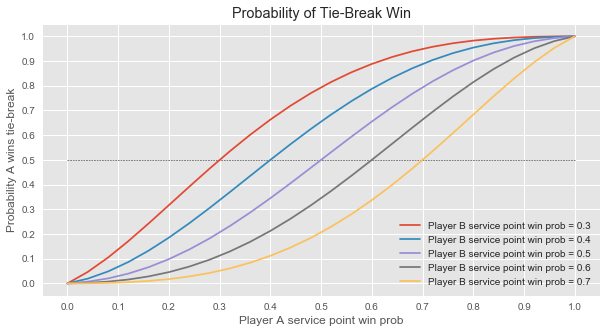

In [82]:
fig, ax = plt.subplots(figsize=(10,5))
for b in win_probs:
    ax.plot(a_probs, win_probs[b], label=f'Player B service point win prob = {b:.1f}')
ax.hlines(0.5, 0, 1, linestyles='dashed', linewidth=0.5, color='k')
TICKS = 10
ax.set_xticks(np.arange(0, 1+1/TICKS, 1/TICKS))
ax.set_yticks(np.arange(0, 1+1/TICKS, 1/TICKS))
ax.set_xlabel('Player A service point win prob')
ax.set_ylabel('Probability A wins tie-break')
ax.set_title(f'Probability of Tie-Break Win')
ax.legend(loc='lower right')
plt.show()